In [113]:
import pandas as pd
import numpy as np
import torch
import re
import matplotlib.pyplot as plt


In [114]:

class ToSoccerMapTensor:
    """Convert inputs to a spatial representation.

    Parameters
    ----------
    dim : tuple(int), default=(68, 104)
        The dimensions of the pitch in the spatial representation.
    """

    def __init__(self, dim=(68, 104)):
        assert len(dim) == 2
        self.y_bins, self.x_bins = dim

    def _get_cell_indexes(self, x, y):
        x_bin = np.clip((x + 52.5) / 105 * self.x_bins, 0, self.x_bins - 1).astype(np.uint8)
        y_bin = np.clip((y + 34) / 68 * self.y_bins, 0, self.y_bins - 1).astype(np.uint8)
        return x_bin, y_bin

    def __call__(self, sample):
        pass_outcome_mapping = {
            'C': 1,
            'D': 0,
            'B': 0,
            'O': 0,
            'S': 0,
            'G': 0,
            'I': 0,
            
        }
        start_x, start_y, end_x, end_y = (
            sample["ball_x_start"],
            sample["ball_y_start"],
            sample["ball_x_end"],
            sample["ball_y_end"],
        )
        speed_x, speed_y = sample["vx_carrier"], sample["vy_carrier"]
        frame = sample["frame"]

        pass_outcome_type = sample.get("pass_outcome_type")
        pass_outcome_type_mapped = pass_outcome_mapping.get(pass_outcome_type, None)
        if pass_outcome_type_mapped is None:
            raise ValueError(f"Invalid pass_outcome_type: {pass_outcome_type}")
        target = int(pass_outcome_type_mapped)

        ball_coo = np.array([[start_x, start_y]])
        goal_coo = np.array([[52.5, 0]])
        team_id = sample['team_id']
        player_columns = [col for col in frame.columns if col.startswith('x_player_')]

        players_att_coo = []
        players_def_coo = []

        for player_col in player_columns:
            player_id = player_col.split('_')[-1]
            x_col = f'x_player_{player_id}'
            y_col = f'y_player_{player_id}'

            team_id_col = frame[f'team_id_player_{player_id}']
            if not pd.isna(team_id_col).all():  # Ensure there are no NaN values
                if int(team_id_col) == team_id:
                    players_att_coo.append([frame[x_col], frame[y_col]])
                else:
                    players_def_coo.append([frame[x_col], frame[y_col]])

        players_att_coo = np.array(players_att_coo)
        players_def_coo = np.array(players_def_coo)

        matrix = np.zeros((17, self.y_bins, self.x_bins))

        # Channel 1: Locations of attacking team
        x_bin_att, y_bin_att = self._get_cell_indexes(players_att_coo[:, 0], players_att_coo[:, 1])
        matrix[0, y_bin_att, x_bin_att] = 1

        # Channel 2: Locations of defending team
        x_bin_def, y_bin_def = self._get_cell_indexes(players_def_coo[:, 0], players_def_coo[:, 1])
        matrix[1, y_bin_def, x_bin_def] = 1

        # Channel 3: Distance to ball
        yy, xx = np.ogrid[0.5: self.y_bins, 0.5: self.x_bins]
        x0_ball, y0_ball = self._get_cell_indexes(ball_coo[:, 0], ball_coo[:, 1])
        matrix[2, :, :] = np.sqrt((xx - x0_ball) ** 2 + (yy - y0_ball) ** 2)

        # Channel 4: Distance to goal
        x0_goal, y0_goal = self._get_cell_indexes(goal_coo[:, 0], goal_coo[:, 1])
        matrix[3, :, :] = np.sqrt((xx - x0_goal) ** 2 + (yy - y0_goal) ** 2)

        # Channel 5: Cosine of the angle between the ball and goal
        coords = np.dstack(np.meshgrid(xx, yy))
        goal_coo_bin = np.concatenate((x0_goal, y0_goal))
        ball_coo_bin = np.concatenate((x0_ball, y0_ball))
        a = goal_coo_bin - coords
        b = ball_coo_bin - coords
        matrix[4, :, :] = np.clip(np.sum(a * b, axis=2) / (np.linalg.norm(a, axis=2) * np.linalg.norm(b, axis=2)), -1, 1)

        # Channel 6: Sine of the angle between the ball and goal
        matrix[5, :, :] = np.sqrt(1 - matrix[4, :, :] ** 2)

        # Channel 7: Angle to the goal location
        matrix[6, :, :] = np.abs(np.arctan2((y0_goal - coords[:, :, 1]), (x0_goal - coords[:, :, 0])))

        # Channels 8-9: Ball speed
        matrix[7, y0_ball, x0_ball] = speed_x
        matrix[8, y0_ball, x0_ball] = speed_y

        # Channel 10: Number of possession team’s players between the ball and every other location
        dist_att_goal = matrix[0, :, :] * matrix[3, :, :]
        dist_att_goal[dist_att_goal == 0] = np.nan
        dist_ball_goal = matrix[3, y0_ball, x0_ball]
        player_in_front_of_ball = dist_att_goal <= dist_ball_goal

        outplayed1 = lambda x: np.sum(player_in_front_of_ball & (x <= dist_ball_goal) & (dist_att_goal >= x))
        matrix[9, :, :] = np.vectorize(outplayed1)(matrix[3, :, :])

        # Channel 11: Number of opponent team’s players between the ball and every other location
        dist_def_goal = matrix[1, :, :] * matrix[3, :, :]
        dist_def_goal[dist_def_goal == 0] = np.nan
        dist_ball_goal = matrix[3, y0_ball, x0_ball]
        player_in_front_of_ball = dist_def_goal <= dist_ball_goal

        outplayed2 = lambda x: np.sum(player_in_front_of_ball & (x <= dist_ball_goal) & (dist_def_goal >= x))
        matrix[10, :, :] = np.vectorize(outplayed2)(matrix[3, :, :])

        # Channel 12: Carrier's velocity
        carrier_velocity = sample["carrier_velocity"]
        matrix[11, y0_ball, x0_ball] = carrier_velocity

        # Channels 13-14: Possession team players' velocity (x and y)
        players_ve_att_coo = []
        players_ve_def_coo = []
        for player_col in player_columns:
            player_id = player_col.split('_')[-1]
            x_col = f'vx_player_{player_id}'
            y_col = f'vy_player_{player_id}'

            team_id_col = frame[f'team_id_player_{player_id}']
            if not pd.isna(team_id_col).all():  # Ensure there are no NaN values
                if int(team_id_col) == team_id:
                    players_ve_att_coo.append([frame[x_col], frame[y_col]])
                else:
                    players_ve_def_coo.append([frame[x_col], frame[y_col]])
                    
        
        x_bin_att_vel, y_bin_att_vel = self._get_cell_indexes(players_att_coo[:, 0], players_att_coo[:, 1])
        for i in range(len(players_ve_att_coo)):
            if 0 <= x_bin_att_vel[i] < matrix.shape[2] and 0 <= y_bin_att_vel[i] < matrix.shape[1]:
                matrix[12, y_bin_att_vel[i], x_bin_att_vel[i]] = players_ve_att_coo[i][0]
                matrix[13, y_bin_att_vel[i], x_bin_att_vel[i]] = players_ve_att_coo[i][1]
                
        
        # Channels 15-16: Defending team players' velocity (x and y)
        x_bin_def_vel, y_bin_def_vel = self._get_cell_indexes(players_def_coo[:, 0], players_def_coo[:, 1])
        for i in range(len(players_ve_att_coo)):
            if 0 <= x_bin_att_vel[i] < matrix.shape[2] and 0 <= y_bin_att_vel[i] < matrix.shape[1]:
                matrix[14, y_bin_def_vel[i], x_bin_def_vel[i]] = players_ve_def_coo[i][0]
                matrix[15, y_bin_def_vel[i], x_bin_def_vel[i]] = players_ve_def_coo[i][1]
                
                
        # Channel 17: Distance to event's origin location
        x0_start, y0_start = self._get_cell_indexes(np.array([start_x]), np.array([start_y]))
        matrix[16, :, :] = np.sqrt((xx - x0_start) ** 2 + (yy - y0_start) ** 2)

        mask = np.zeros((1, self.y_bins, self.x_bins))
        end_ball_coo = np.array([[end_x, end_y]])
        if np.isnan(end_ball_coo).any():
            raise ValueError("End coordinates not known.")
        x0_ball_end, y0_ball_end = self._get_cell_indexes(end_ball_coo[:, 0], end_ball_coo[:, 1])
        mask[0, y0_ball_end, x0_ball_end] = 1

        return (
            torch.from_numpy(matrix).float(),
            torch.from_numpy(mask).float(),
            torch.tensor([target]).float()
        )

In [115]:
df = pd.read_csv('/home_cerberus/disk2/diogochaves/FUTEBOL/Simplified_EPV_in_PFF_Data/data/Pass/final_pass_track_4585.csv')

In [116]:
df['vx_player_17']

0     -2.16
1     -1.98
2     -2.10
3     -2.25
4     -2.46
       ... 
446    0.09
447   -0.15
448   -1.23
449   -0.30
450   -1.05
Name: vx_player_17, Length: 451, dtype: float64

In [117]:
df.columns[200:]

Index(['vx_player_15', 'vx_player_16', 'vx_player_17', 'vx_player_18',
       'vx_player_19', 'vx_player_20', 'vx_player_21', 'vx_player_22',
       'vy_player_1', 'vy_player_2',
       ...
       'atot_player_13', 'atot_player_14', 'atot_player_15', 'atot_player_16',
       'atot_player_17', 'atot_player_18', 'atot_player_19', 'atot_player_20',
       'atot_player_21', 'atot_player_22'],
      dtype='object', length=118)

In [118]:
for idx, row in df[100:123].iterrows():
    player_id = int(row["player_id"])

    # Finding the column that matches the condition
    passerPlayerColumn = [
        column.replace('original_pId_player_', '')
        for column in df.columns
        if 'original_pId_player' in column and player_id in df[column].values
    ]
    
    if passerPlayerColumn:  # Check if the list is not empty
        passerPlayerColumn = int(passerPlayerColumn[0])
        df.loc[idx, 'carrier_velocity'] = np.sqrt(
            df.loc[idx, f'vx_player_{passerPlayerColumn}']**2 +
            df.loc[idx, f'vy_player_{passerPlayerColumn}']**2
        )
        df.loc[idx, 'vx_carrier'] = df.loc[idx, f'vx_player_{passerPlayerColumn}']
        df.loc[idx, 'vy_carrier'] = df.loc[idx, f'vy_player_{passerPlayerColumn}']
        
    sample = {
        "ball_x_start": row["ball_x_start"],
        "ball_y_start": row["ball_y_start"],
        "ball_x_end": row["ball_x_end"],
        "ball_y_end": row["ball_y_end"],
        "pass_outcome_type": row["pass_outcome_type"],
        "team_id": row["team_id"],
        "vx_carrier": df.loc[idx, 'vx_carrier'],
        "vy_carrier":df.loc[idx, 'vx_carrier'],
        "carrier_velocity": df.loc[idx, 'carrier_velocity'],
        "frame": df.loc[[idx]],
    }

In [119]:

tensor_converter = ToSoccerMapTensor()
matrix, mask, target = tensor_converter(sample)

/tmp/ipykernel_2692040/3241896563.py:60: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(team_id_col) == team_id:
/tmp/ipykernel_2692040/3241896563.py:137: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  if int(team_id_col) == team_id:


In [120]:
has_nan = torch.isnan(matrix)

nan_indices = [i for i in range(matrix.size(0)) if torch.any(has_nan[i])]

print("Índices com NaNs na primeira dimensão:", nan_indices)

Índices com NaNs na primeira dimensão: []


/home/phocus4/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/phocus4/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/phocus4/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/home/phocus4/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecati

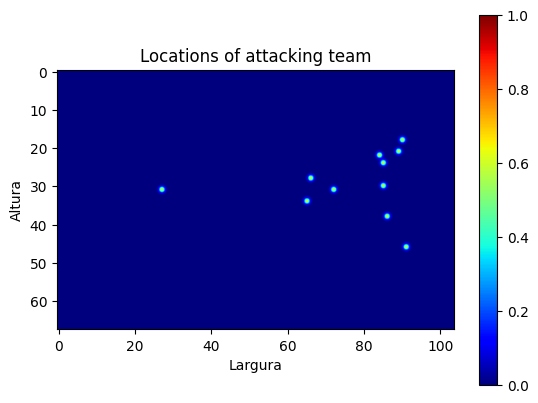

In [121]:
plt.imshow(matrix[0], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Locations of attacking team")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

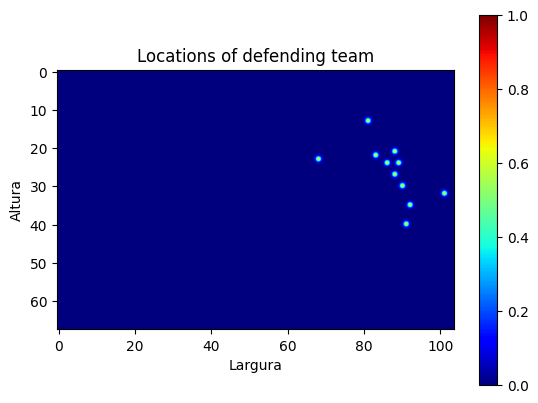

In [122]:
plt.imshow(matrix[1], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Locations of defending team")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

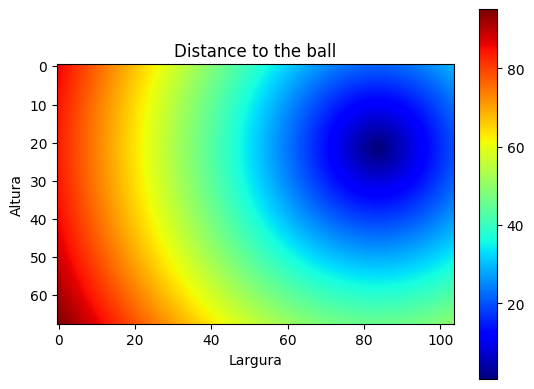

In [123]:
plt.imshow(matrix[2], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Distance to the ball")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

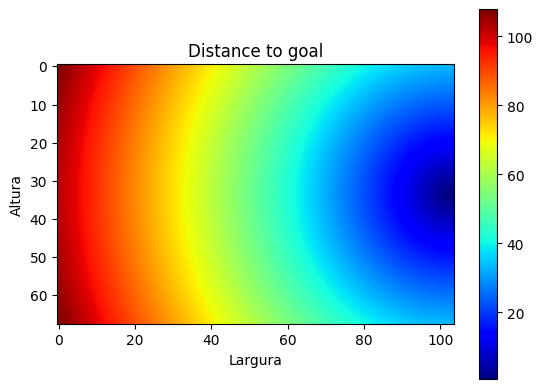

In [124]:
plt.imshow(matrix[3], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Distance to goal")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

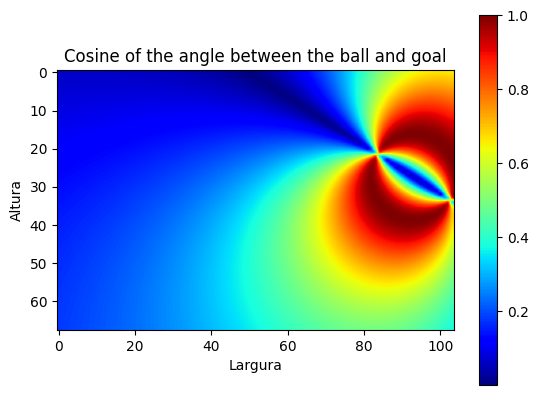

In [125]:
plt.imshow(matrix[5], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Cosine of the angle between the ball and goal")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

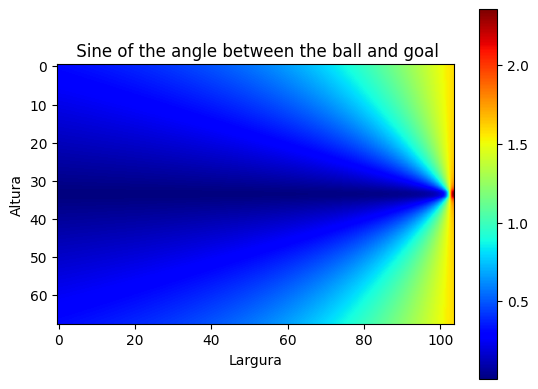

In [126]:
plt.imshow(matrix[6], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title(" Sine of the angle between the ball and goal")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

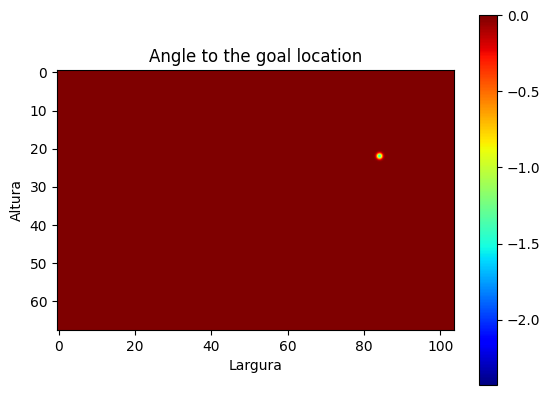

In [127]:
plt.imshow(matrix[7], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Angle to the goal location")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

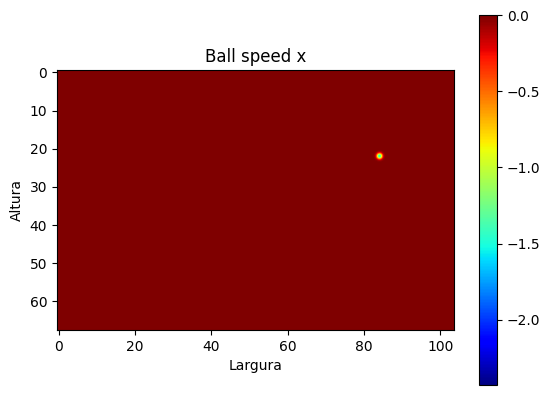

In [128]:
plt.imshow(matrix[8], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Ball speed x")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

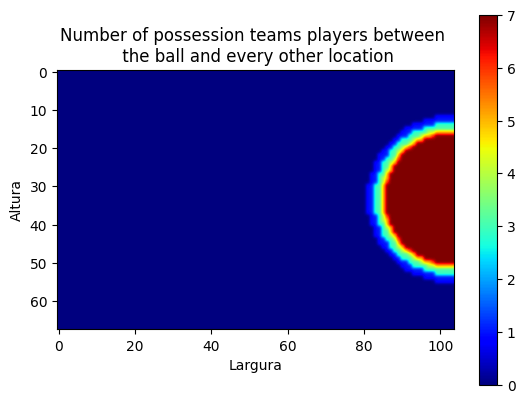

In [129]:
plt.imshow(matrix[9], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Number of possession teams players between \n the ball and every other location")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

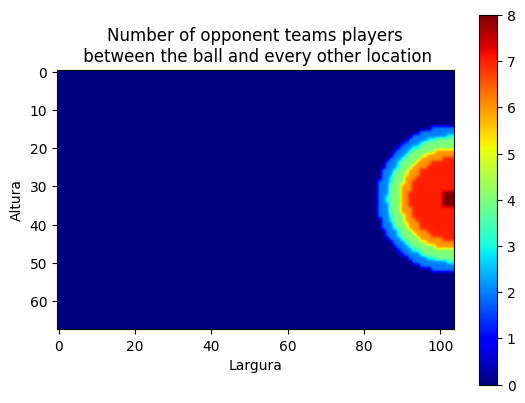

In [130]:
plt.imshow(matrix[10], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Number of opponent teams players\n between the ball and every other location")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

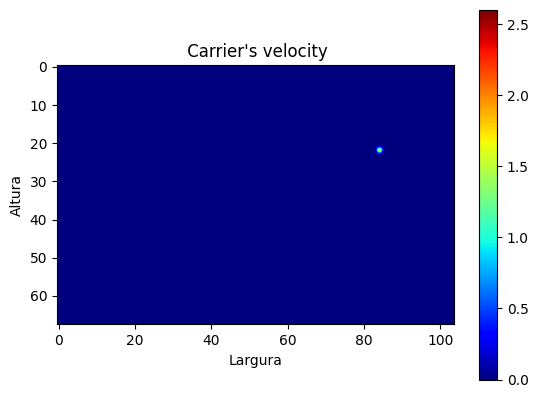

In [131]:
plt.imshow(matrix[11], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title(" Carrier's velocity")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

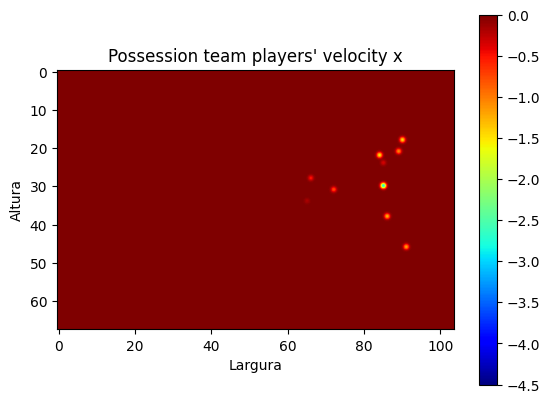

In [132]:
plt.imshow(matrix[12], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Possession team players' velocity x")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

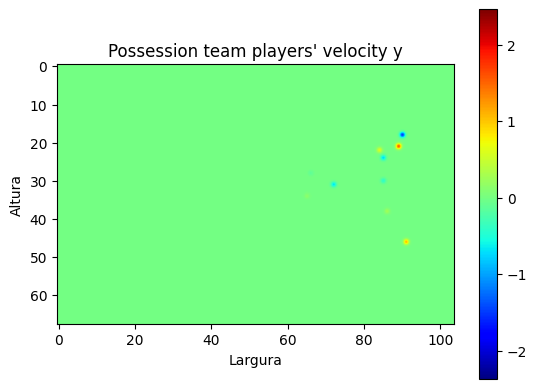

In [133]:
plt.imshow(matrix[13], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Possession team players' velocity y")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

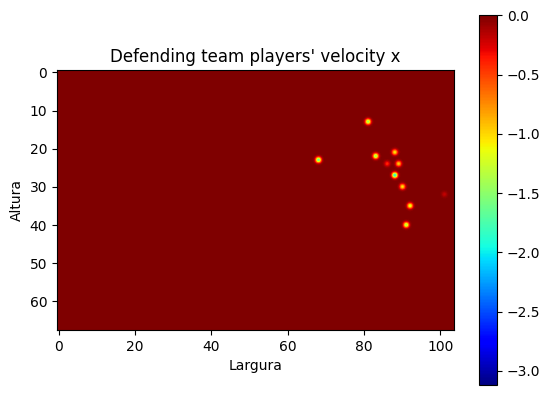

In [140]:
plt.imshow(matrix[14], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Defending team players' velocity x")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

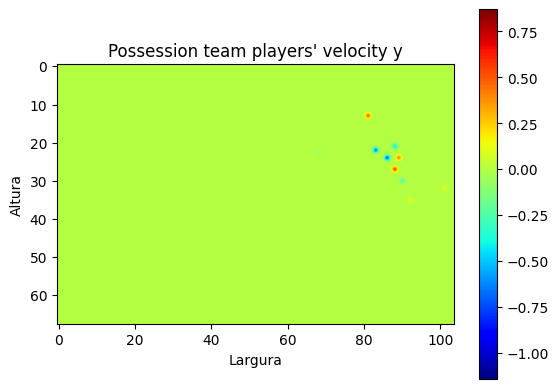

In [142]:
plt.imshow(matrix[15], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Possession team players' velocity y")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

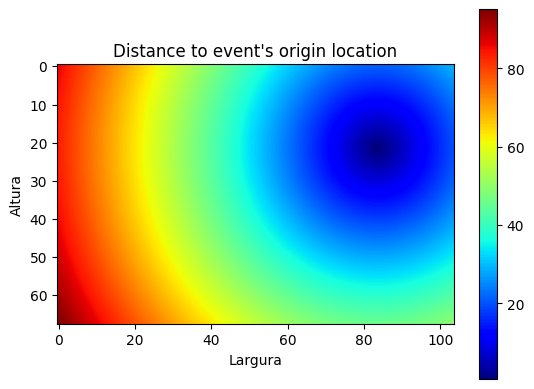

In [143]:
plt.imshow(matrix[16], cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Distance to event's origin location")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

In [135]:
matrix

tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[86.2235, 85.2555, 84.2882,  ..., 27.7218, 28.3637, 29.0259],
         [85.9797, 85.0088, 84.0387,  ..., 26

In [136]:
"""Implements the SoccerMap architecture."""
from typing import List

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F  # noqa: N812
import matplotlib.pyplot as plt


class _FeatureExtractionLayer(nn.Module):
    """The 2D-convolutional feature extraction layer of the SoccerMap architecture.

    The probability at a single location is influenced by the information we
    have of nearby pixels. Therefore, convolutional filters are used for
    spatial feature extraction.

    Two layers of 2D convolutional filters with a 5 × 5 receptive field and
    stride of 1 are applied, each one followed by a ReLu activation function.
    To keep the same dimensions after the convolutional filters, symmetric
    padding is applied. It fills the padding cells with values that are
    similar to those around it, thus avoiding border-image artifacts that can
    hinder the model’s predicting ability and visual representation.
    """

    def __init__(self, in_channels):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels, 32, kernel_size=(5, 5), stride=1, padding="valid")
        self.conv_2 = nn.Conv2d(32, 64, kernel_size=(5, 5), stride=1, padding="valid")
        # (left, right, top, bottom)
        self.symmetric_padding = nn.ReplicationPad2d((2, 2, 2, 2))

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.symmetric_padding(x)
        x = F.relu(self.conv_2(x))
        x = self.symmetric_padding(x)
        return x


class _PredictionLayer(nn.Module):
    """The prediction layer of the SoccerMap architecture.

    The prediction layer consists of a stack of two convolutional layers, the
    first with 32 1x1 convolutional filters followed by an ReLu activation
    layer, and the second consists of one 1x1 convolutional filter followed by
    a linear activation layer. The spatial dimensions are kept at each step
    and 1x1 convolutions are used to produce predictions at each location.
    """

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(64, 32, kernel_size=(1, 1))
        self.conv2 = nn.Conv2d(32, 1, kernel_size=(1, 1))

    def forward(self, x: torch.Tensor):
        x = F.relu(self.conv1(x))
        x = self.conv2(x)  # linear activation
        return x


class _UpSamplingLayer(nn.Module):
    """The upsampling layer of the SoccerMap architecture.

    The upsampling layer provides non-linear upsampling by first applying a 2x
    nearest neighbor upsampling and then two layers of convolutional filters.
    The first convolutional layer consists of 32 filters with a 3x3 activation
    field and stride 1, followed by a ReLu activation layer. The second layer
    consists of 1 layer with a 3x3 activation field and stride 1, followed by
    a linear activation layer. This upsampling strategy has been shown to
    provide smoother outputs.
    """

    def __init__(self):
        super().__init__()
        self.up = nn.UpsamplingNearest2d(scale_factor=2)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=1, padding="valid")
        self.conv2 = nn.Conv2d(32, 1, kernel_size=(3, 3), stride=1, padding="valid")
        self.symmetric_padding = nn.ReplicationPad2d((1, 1, 1, 1))

    def forward(self, x: torch.Tensor):
        x = self.up(x)
        x = F.relu(self.conv1(x))
        x = self.symmetric_padding(x)
        x = self.conv2(x)  # linear activation
        x = self.symmetric_padding(x)
        return x


class _FusionLayer(nn.Module):
    """The fusion layer of the SoccerMap architecture.

    The fusion layer merges the final prediction surfaces at different scales
    to produce a final prediction. It concatenates the pair of matrices and
    passes them through a convolutional layer of one 1x1 filter.
    """

    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=(1, 1), stride=1)

    def forward(self, x: List[torch.Tensor]):
        out = self.conv(torch.cat(x, dim=1))  # linear activation
        return out


class SoccerMap(nn.Module):
    """SoccerMap architecture.

    SoccerMap is a deep learning architecture that is capable of estimating
    full probability surfaces for pass probability, pass slection likelihood
    and pass expected values from spatiotemporal data.

    The input consists of a stack of c matrices of size lxh, each representing a
    subset of the available spatiotemporal information in the current
    gamestate. The specific choice of information for each of these c slices
    might vary depending on the problem being solved

    Parameters
    ----------
    in_channels : int, default: 13
        The number of spatiotemporal input channels.

    References
    ----------
    .. [1] Fernández, Javier, and Luke Bornn. "Soccermap: A deep learning
       architecture for visually-interpretable analysis in soccer." Joint
       European Conference on Machine Learning and Knowledge Discovery in
       Databases. Springer, Cham, 2020.
    """

    def __init__(self, in_channels=13):
        super().__init__()

        # Convolutions for feature extraction at 1x, 1/2x and 1/4x scale
        self.features_x1 = _FeatureExtractionLayer(in_channels)
        self.features_x2 = _FeatureExtractionLayer(64)
        self.features_x4 = _FeatureExtractionLayer(64)

        # Layers for down and upscaling and merging scales
        self.up_x2 = _UpSamplingLayer()
        self.up_x4 = _UpSamplingLayer()
        self.down_x2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.down_x4 = nn.MaxPool2d(kernel_size=(2, 2))
        self.fusion_x2_x4 = _FusionLayer()
        self.fusion_x1_x2 = _FusionLayer()

        # Prediction layers at each scale
        self.prediction_x1 = _PredictionLayer()
        self.prediction_x2 = _PredictionLayer()
        self.prediction_x4 = _PredictionLayer()
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Feature extraction
        f_x1 = self.features_x1(x)
        f_x2 = self.features_x2(self.down_x2(f_x1))
        f_x4 = self.features_x4(self.down_x4(f_x2))

        # Prediction
        pred_x1 = self.prediction_x1(f_x1)
        pred_x2 = self.prediction_x2(f_x2)
        pred_x4 = self.prediction_x4(f_x4)

        # Fusion
        x4x2combined = self.fusion_x2_x4([self.up_x4(pred_x4), pred_x2])
        combined = self.fusion_x1_x2([self.up_x2(x4x2combined), pred_x1])

        # The activation function depends on the problem
        return self.sigmoid(combined)


def pixel(surface, mask):
    """Return the prediction at a single pixel.

    This custom layer is used to evaluate the loss at the pass destination.

    Parameters
    ----------
    surface : torch.Tensor
        The final prediction surface.
    mask : torch.Tensor
        A sparse spatial representation of the final pass destination.

    Returns
    -------
    torch.Tensor
        The prediction at the cell on the surface that matches the actual
        pass destination.
    """
    masked = surface * mask
    value = torch.sum(masked, dim=(3, 2))
    return value





tensor([[0.5554]], grad_fn=<SumBackward1>)
tensor([[[[0.5558, 0.5558, 0.5558,  ..., 0.5578, 0.5578, 0.5578],
          [0.5558, 0.5558, 0.5558,  ..., 0.5578, 0.5578, 0.5578],
          [0.5558, 0.5558, 0.5558,  ..., 0.5578, 0.5578, 0.5578],
          ...,
          [0.5564, 0.5564, 0.5564,  ..., 0.5568, 0.5568, 0.5568],
          [0.5564, 0.5564, 0.5564,  ..., 0.5568, 0.5568, 0.5568],
          [0.5564, 0.5564, 0.5564,  ..., 0.5568, 0.5568, 0.5568]]]],
       grad_fn=<SigmoidBackward0>)


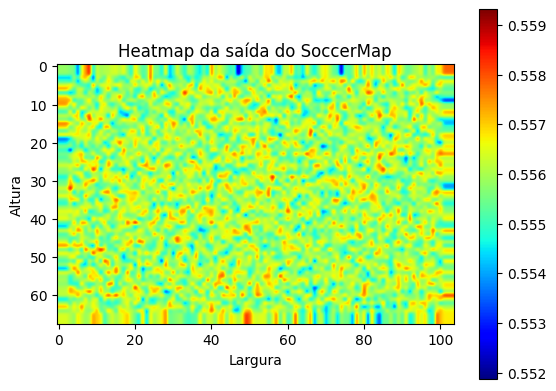

In [137]:
torch.manual_seed(42)

# Definindo as dimensões da entrada
batch_size = 1
in_channels = 15
height = 68
width = 104

# Criando uma entrada aleatória
input_tensor = torch.randn(batch_size, in_channels, height, width)

# Instanciando o modelo SoccerMap
model = SoccerMap(in_channels=in_channels)

# Passando a entrada pelo modelo
output = model(input_tensor)

mask = np.zeros((height, width), dtype=int)

pos_x = 21
pos_y = 21

# Colocando o valor 1 na posição (21, 21)
mask[pos_x, pos_y] = 1
mask = torch.tensor(mask)
print(pixel(output,mask))

print(output)
# Convertendo a saída para numpy e removendo dimensões extras
output_np = output.detach().numpy().squeeze()


# Plotando o heatmap
plt.imshow(output_np, cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Heatmap da saída do SoccerMap")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

In [138]:
matriz_2 = matrix.unsqueeze(0)

In [139]:
model = SoccerMap(in_channels=15)
output = model(matriz_2)
output_np = output.detach().numpy().squeeze()

plt.imshow(output_np, cmap='jet', interpolation='gaussian')
plt.colorbar()
plt.title("Heatmap da saída do SoccerMap")
plt.xlabel("Largura")
plt.ylabel("Altura")
plt.show()

RuntimeError: Given groups=1, weight of size [32, 15, 5, 5], expected input[1, 17, 68, 104] to have 15 channels, but got 17 channels instead

In [ ]:
output

tensor([[[[0.4913, 0.4913, 0.4913,  ..., 0.3305, 0.3305, 0.3305],
          [0.4913, 0.4913, 0.4913,  ..., 0.3305, 0.3305, 0.3305],
          [0.4913, 0.4913, 0.4913,  ..., 0.3305, 0.3305, 0.3305],
          ...,
          [0.4818, 0.4818, 0.4818,  ..., 0.3311, 0.3311, 0.3311],
          [0.4818, 0.4818, 0.4818,  ..., 0.3311, 0.3311, 0.3311],
          [0.4818, 0.4818, 0.4818,  ..., 0.3311, 0.3311, 0.3311]]]],
       grad_fn=<SigmoidBackward0>)

In [ ]:
pixel(output,mask)[0][0]

tensor(0.4860, grad_fn=<SelectBackward0>)

In [ ]:
has_nan = torch.isnan(matrix)

nan_indices = [i for i in range(matrix.size(0)) if torch.any(has_nan[i])]

print("Índices com NaNs na primeira dimensão:", nan_indices)

Índices com NaNs na primeira dimensão: []


In [ ]:
int(target[0])

1

In [ ]:
df.iloc[:1]

,game_id,period,game_event_id,possession_event_id,player_id,shirt_number,possession_event_type,position_group_type,team_id,home_team,...,atot_player_16,atot_player_17,atot_player_18,atot_player_19,atot_player_20,atot_player_21,atot_player_22,carrier_velocity,vx_carrier,vy_carrier
0,4585,1.0,6198908.0,6065157.0,52.0,14.0,PA,AM,4.0,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [ ]:
(spatial_representations.size)

NameError: name 'spatial_representations' is not defined

In [ ]:
type(spatial_representations)

pandas.core.series.Series

In [ ]:
(len(spatial_representations[0]))

3

In [ ]:
type(spatial_representations[0])

tuple

In [ ]:
(len(spatial_representations[0][0]))

19

In [ ]:
type(spatial_representations[0][0])

torch.Tensor

In [ ]:
(len(spatial_representations[0][0][0]))

68

In [ ]:
type(spatial_representations[0][0][0])

torch.Tensor

In [ ]:
(len(spatial_representations[0][0][0][0]))

104

In [ ]:
type(spatial_representations[0][0][0][0])

torch.Tensor

(pandas.core.series.Series,tuple,torch.Tensor,torch.Tensor)
(1,3,19,68,104)

In [ ]:
class ToSoccerMapTensor:
    """Convert inputs to a spatial representation.

    Parameters
    ----------
    dim : tuple(int), default=(68, 104)
        The dimensions of the pitch in the spatial representation.
    """

    def __init__(self, dim=(68, 104)):
        assert len(dim) == 2
        self.y_bins, self.x_bins = dim

    def _get_cell_indexes(self, x, y):
        x_bin = np.clip((x + 52.5) / 105 * self.x_bins, 0, self.x_bins - 1).astype(np.uint8)
        y_bin = np.clip((y + 34) / 68 * self.y_bins, 0, self.y_bins - 1).astype(np.uint8)
        return x_bin, y_bin

    def __call__(self, sample):
        start_x, start_y, end_x, end_y = (
            sample["ball_x_start"],
            sample["ball_y_start"],
            sample["ball_x_end"],
            sample["ball_y_end"],
        )
        speed_x, speed_y = sample["vx_player_201"], sample["vy_player_201"]
        frame = sample["frame"]

        pass_outcome_type = sample.get("pass_outcome_type")
        pass_outcome_type_mapped = pass_outcome_mapping.get(pass_outcome_type, None)
        if pass_outcome_type_mapped is None:
            raise ValueError(f"Invalid pass_outcome_type: {pass_outcome_type}")
        target = int(pass_outcome_type_mapped)

        ball_coo = np.array([[start_x, start_y]])
        goal_coo = np.array([[52.5, 0]])

        players_att_coo = frame.loc[frame["team_id"] == sample["team_id"], ["x_player_201", "y_player_201"]].values.reshape(-1, 2)
        players_def_coo = frame.loc[frame["team_id"] != sample["team_id"], ["x_player_201", "y_player_201"]].values.reshape(-1, 2)

        matrix = np.zeros((15, self.y_bins, self.x_bins))

        # Channel 1: Locations of attacking team
        x_bin_att, y_bin_att = self._get_cell_indexes(players_att_coo[:, 0], players_att_coo[:, 1])
        matrix[0, y_bin_att, x_bin_att] = 1

        # Channel 2: Locations of defending team
        x_bin_def, y_bin_def = self._get_cell_indexes(players_def_coo[:, 0], players_def_coo[:, 1])
        matrix[1, y_bin_def, x_bin_def] = 1

        # Channel 3: Distance to ball
        yy, xx = np.ogrid[0.5: self.y_bins, 0.5: self.x_bins]
        x0_ball, y0_ball = self._get_cell_indexes(ball_coo[:, 0], ball_coo[:, 1])
        matrix[2, :, :] = np.sqrt((xx - x0_ball) * 2 + (yy - y0_ball) * 2)

        # Channel 4: Distance to goal
        x0_goal, y0_goal = self._get_cell_indexes(goal_coo[:, 0], goal_coo[:, 1])
        matrix[3, :, :] = np.sqrt((xx - x0_goal) * 2 + (yy - y0_goal) * 2)

        # Channel 5: Cosine of the angle between the ball and goal
        coords = np.dstack(np.meshgrid(xx, yy))
        goal_coo_bin = np.concatenate((x0_goal, y0_goal))
        ball_coo_bin = np.concatenate((x0_ball, y0_ball))
        a = goal_coo_bin - coords
        b = ball_coo_bin - coords
        matrix[4, :, :] = np.clip(np.sum(a * b, axis=2) / (np.linalg.norm(a, axis=2) * np.linalg.norm(b, axis=2)), -1, 1)

        # Channel 6: Sine of the angle between the ball and goal
        matrix[5, :, :] = np.sqrt(1 - matrix[4, :, :] ** 2)

        # Channel 7: Angle to the goal location
        matrix[6, :, :] = np.abs(np.arctan2((y0_goal - coords[:, :, 1]), (x0_goal - coords[:, :, 0])))

        # Channels 8-9: Ball speed
        matrix[7, y0_ball, x0_ball] = speed_x
        matrix[8, y0_ball, x0_ball] = speed_y

        # Channel 10: Number of possession team’s players between the ball and every other location
        dist_att_goal = matrix[0, :, :] * matrix[3, :, :]
        dist_att_goal[dist_att_goal == 0] = np.nan
        dist_ball_goal = matrix[3, y0_ball, x0_ball]
        player_in_front_of_ball = dist_att_goal <= dist_ball_goal

        outplayed1 = lambda x: np.sum(player_in_front_of_ball & (x <= dist_ball_goal) & (dist_att_goal >= x))
        matrix[9, :, :] = np.vectorize(outplayed1)(matrix[3, :, :])

        # Channel 11: Number of opponent team’s players between the ball and every other location
        dist_def_goal = matrix[1, :, :] * matrix[3, :, :]
        dist_def_goal[dist_def_goal == 0] = np.nan
        dist_ball_goal = matrix[3, y0_ball, x0_ball]
        player_in_front_of_ball = dist_def_goal <= dist_ball_goal

        outplayed2 = lambda x: np.sum(player_in_front_of_ball & (x <= dist_ball_goal) & (dist_def_goal >= x))
        matrix[10, :, :] = np.vectorize(outplayed2)(matrix[3, :, :])

        # Channel 12: Carrier's velocity
        carrier_velocity = sample["carrier_velocity"]
        matrix[11, y0_ball, x0_ball] = carrier_velocity

        # Channels 13-14: Possession team players' velocity (x and y)
        players_vel_coo = frame.loc[frame["team_id"] == sample["team_id"], ["vx_player_201", "vy_player_201"]].values
        x_bin_att_vel, y_bin_att_vel = self._get_cell_indexes(players_att_coo[:, 0], players_att_coo[:, 1])
        matrix[12, y_bin_att_vel, x_bin_att_vel] = players_vel_coo[:, 0]
        matrix[13, y_bin_att_vel, x_bin_att_vel] = players_vel_coo[:, 1]

        # Channel 15: Distance to event's origin location
        x0_start, y0_start = self._get_cell_indexes(np.array([start_x]), np.array([start_y]))
        matrix[14, :, :] = np.sqrt((xx - x0_start) * 2 + (yy - y0_start) * 2)

        mask = np.zeros((1, self.y_bins, self.x_bins))
        end_ball_coo = np.array([[end_x, end_y]])
        if np.isnan(end_ball_coo).any():
            raise ValueError("End coordinates not known.")
        x0_ball_end, y0_ball_end = self._get_cell_indexes(end_ball_coo[:, 0], end_ball_coo[:, 1])
        mask[0, y0_ball_end, x0_ball_end] = 1

        return (
            torch.from_numpy(matrix).float(),
            torch.from_numpy(mask).float(),
            torch.tensor([target]).float()
        )
pass_outcome_mapping = {
    'C': 0,
    'D': 1,
    'B': 2,
    'O': 3,
    'S': 4
}
sample = {
    "ball_x_start": df.iloc[1:2]["ball_x_start"].iloc[0],
    "ball_y_start": df.iloc[1:2]["ball_y_start"].iloc[0],
    "ball_x_end": df.iloc[1:2]["ball_x_end"].iloc[0],
    "ball_y_end": df.iloc[1:2]["ball_y_end"].iloc[0],
    "vx_player_201": df.iloc[1:2]["vx_player_201"].iloc[0],
    "vy_player_201": df.iloc[1:2]["vy_player_201"].iloc[0],
    "pass_outcome_type": df.iloc[1:2]["pass_outcome_type"].iloc[0],
    "team_id": df.iloc[1:2]["team_id"].iloc[0],
    "carrier_velocity": df.iloc[1:2]["carrier_velocity"].iloc[0],
    "frame": df.iloc[1:2]  
}

tensor_converter = ToSoccerMapTensor()
matrix, mask, target = tensor_converter(sample)

/tmp/ipykernel_11417/2553297429.py:54: RuntimeWarning: invalid value encountered in sqrt
  matrix[2, :, :] = np.sqrt((xx - x0_ball) * 2 + (yy - y0_ball) * 2)
/tmp/ipykernel_11417/2553297429.py:58: RuntimeWarning: invalid value encountered in sqrt
  matrix[3, :, :] = np.sqrt((xx - x0_goal) * 2 + (yy - y0_goal) * 2)
/tmp/ipykernel_11417/2553297429.py:108: RuntimeWarning: invalid value encountered in sqrt
  matrix[14, :, :] = np.sqrt((xx - x0_start) * 2 + (yy - y0_start) * 2)


In [ ]:
target

tensor([0.])